In [242]:
import pickle
import numpy as np
import pandas as pd
import sys
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

In [601]:
_DIR = 'china_import'
_FILE_DIR = './../output'
DATA_DIR = './../../../generated_data'

In [602]:
with open(os.path.join(_FILE_DIR, _DIR, 'train_embedding_values.pkl'),'rb') as fh:
    arr = pickle.load(fh)
    
with open(os.path.join(DATA_DIR, _DIR, 'domain_dims.pkl'),'rb') as fh:
    domain_dims =  pickle.load(fh)
    
train_x = arr[0]
train_x_emb = arr[1]
emb_size = train_x_emb.shape[-1]

# create arrays for each domain


In [603]:
domain_sizes = list(domain_dims.values())
domain_names = list(domain_dims.keys())
domain_emb_dict = {}

In [604]:
domain_id2name = {e[0]:e[1] for e in enumerate(domain_names,0)}
domain_name2id = {e[1]:e[0] for e in enumerate(domain_names,0)}

In [605]:
for _ds,_dn in zip(domain_sizes, domain_names):
    a = np.zeros([_ds,emb_size])
    domain_emb_dict[domain_name2id[_dn]] = a

In [606]:
domain_emb_dict[1].shape

(3375, 12)

In [607]:
num_cols =  train_x_emb.shape[1]
for c in range(num_cols):
    ids = train_x[:,c]
    vals = train_x_emb[:,c,:]
    ids = np.reshape(ids,[-1,1])
    tmp = np.hstack([ids,vals])
    _df = pd.DataFrame(tmp)
    _df = _df.rename(columns={0:'id'})
    _df = _df.drop_duplicates(subset=['id'])
   
    for i,row in _df.iterrows():
        _id = int(row['id'])
        z = row.values
        domain_emb_dict[c][_id] = z[1:]

In [608]:
c = 1

In [609]:
test_x_df_file = os.path.join(DATA_DIR, _DIR, 'test_data.csv')
anomalies_c_df_file = os.path.join(DATA_DIR, _DIR, "anomalies_c{}_data.csv".format(c))

In [610]:
# select 100 of the test instances


In [611]:
anomalies_c_df_file

'./../../../generated_data/china_import/anomalies_c1_data.csv'

In [612]:
suffix = '011'

anomalies_c_df = pd.read_csv(anomalies_c_df_file)

In [613]:
def set_ref_id(row):
    _id = row['PanjivaRecordID']
    _id = str(_id)[:-3]
    return int(_id)

In [614]:
anomalies_c_df['ref_id'] = 0
anomalies_c_df['ref_id'] = anomalies_c_df.apply(
    set_ref_id,
    axis=1
)

In [615]:
anomalies_c_df.head(10)

,PanjivaRecordID,AdminRegion,ConsigneePanjivaID,CountryOfSale,Province,ShipmentOrigin,TradeType,TransportMethod,hscode_6,ref_id
0,202269631011,176,2264,57,18,51,3,4,1,202269631
1,202802495011,115,2242,25,22,28,3,1,44,202802495
2,202272191011,176,1741,6,18,20,3,1,44,202272191
3,202212287011,296,2713,11,18,10,3,1,44,202212287
4,202210175011,273,289,103,10,67,3,4,22,202210175
5,202159295011,213,2587,97,18,111,7,4,22,202159295
6,203268287011,30,368,95,24,104,3,1,24,203268287
7,203182847011,6,816,34,24,40,3,1,42,203182847
8,202282431011,305,2775,58,10,62,3,1,42,202282431
9,203409535011,84,2495,99,2,108,3,1,61,203409535


In [616]:
test_df = pd.read_csv(test_x_df_file)
# a_c1_df = pd.read_csv(anomalies_c1_df_file)

In [617]:
count = 4000

In [618]:
len(test_df)

14420

In [619]:
# test_df = test_df.head(count)
anomalies_c_df = anomalies_c_df.loc[anomalies_c_df['ref_id'].isin(list(test_df['PanjivaRecordID']))]


In [620]:
anomalies_c_df.head(10)

,PanjivaRecordID,AdminRegion,ConsigneePanjivaID,CountryOfSale,Province,ShipmentOrigin,TradeType,TransportMethod,hscode_6,ref_id
0,202269631011,176,2264,57,18,51,3,4,1,202269631
1,202802495011,115,2242,25,22,28,3,1,44,202802495
2,202272191011,176,1741,6,18,20,3,1,44,202272191
3,202212287011,296,2713,11,18,10,3,1,44,202212287
4,202210175011,273,289,103,10,67,3,4,22,202210175
5,202159295011,213,2587,97,18,111,7,4,22,202159295
6,203268287011,30,368,95,24,104,3,1,24,203268287
7,203182847011,6,816,34,24,40,3,1,42,203182847
8,202282431011,305,2775,58,10,62,3,1,42,202282431
9,203409535011,84,2495,99,2,108,3,1,61,203409535


In [621]:
# contrast will have : Actual +  Generated Anomaly
contrast_data = []
for i,row in test_df.iterrows():
    t_row_copy= pd.Series(row,copy=True)
    _tmp = anomalies_c_df.loc[anomalies_c_df['ref_id']==row['PanjivaRecordID']]
    del t_row_copy['PanjivaRecordID']
    v = t_row_copy.values
    del _tmp['PanjivaRecordID']
    del _tmp['ref_id']
    try:
        _tmp = (_tmp.values)[0]
        arr = np.vstack([v,_tmp])
        contrast_data.append(arr) 
    except: pass

In [622]:
len(contrast_data)

14346

In [623]:
def get_embedding(id_value, domain_id, domain_emb_dict):
    return domain_emb_dict[domain_id][id_value]

def get_emb_arr(arr,domain_emb_dict):
    tmp = []
    for i in range(len(arr)):
        v = get_embedding(arr[i], i, domain_emb_dict)
        tmp.append(v)
    tmp = np.array(tmp)
    return tmp

In [747]:
def get_reduce_dim(arr,nc=2):
    
    pca = PCA(n_components=nc, svd_solver='full')
    res = pca.fit_transform(arr)
    return np.reshape(res,[-1,nc])

In [624]:
def dissect_v4(arr):
    # calculate projection
    # normalize arr
    p = [_/np.linalg.norm(_, ord=2) for _ in arr]
    arr_sum = np.mean(arr,axis=0)
    
    res = []
    for i in range(arr.shape[0]):
        x = arr[i]
        prj = np.dot(arr_sum,x)/np.linalg.norm(arr_sum, ord=2)
#         print(prj)
        res.append(prj)
    res = np.array(res)
    return res

In [625]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [717]:
pos = 0
l = 0
i = 0
tot_hr = 0
_positive_list = []
for instance in contrast_data[:]:
    i +=1
    n = instance[0]
    a = instance[1]
    diff_indices = np.nonzero(np.bitwise_xor(n, a))[0]
#     print('True   ', a)
#     print('Anomaly', n)
    n_emb = get_emb_arr(n,domain_emb_dict)
    a_emb = get_emb_arr(a,domain_emb_dict)
    
    prj_res = dissect_v4(a_emb)
#     print(prj_res)
    _mean = np.mean(prj_res)
    min_indices = np.where(prj_res < _mean)[0]
    l += len(min_indices)
#     print(min_indices,diff_indices,set(min_indices).intersection(diff_indices))
    hr = len(set(min_indices).intersection(diff_indices))/len(diff_indices)
    tot_hr += hr
    
    if np.argmin(prj_res) == diff_indices[0]:
        if len(np.where(prj_res < 0)[0]) == 1 and _mean > 0:
            _positive_list.append(instance)
            
    norm_n = np.square(np.linalg.norm(np.sum(n_emb,axis=0), ord=2))
    norm_a = np.square(np.linalg.norm(np.sum(a_emb,axis=0), ord=2))
#     print(np.tanh(norm_n) , ' || ', np.tanh(norm_a))      
#     print('----')
    
    

print(pos, len(contrast_data))
print(pos/i)
print(l/i)
print(tot_hr/i)

0 14346
0.0
4.007737348389795
0.6910637111389935


# -------- Visualize ------------ #

x2=cosβx1−sinβy1
y2=sinβx1+cosβy1
 


In [673]:
def rotate_by_Beta(x1,y1, _beta):
    x2 = np.cos(_beta)*x1 - np.sin(_beta) * y1
    y2 = np.sin(_beta)*x1 + np.cos(_beta) * y1
    return x2,y2

In [674]:
def rotate_to_xAxis(x1,y1):
    alpha = np.arccos(x1/(np.sqrt(x1*x1 + y1*y1)))*(180*7/22)
    x2, y2 = rotate_by_Beta(x1,y1, -alpha)
    return x2,y2, alpha




In [675]:
rotate_to_xAxis(0.95,0.95)

(1.3127996327724387, -0.2855820796068096, 44.98189481276295)

In [676]:
np.sqrt(0.7071067811865475 * 0.7071067811865475 + (-5.551115123125783e-17*-5.551115123125783e-17))


0.7071067811865475

In [718]:
len(_positive_list)

147

0.4854562921102105  ||  0.41078965082928787
[0.108 -0.723 0.863 0.327 0.182 -0.840 -0.350 0.433]
 >>  [0.178 0.877 -0.023 0.086 0.183 0.039 -0.025 -0.010 -0.004 -0.342 0.050
 -0.111]
magnitude of mean 1.0
0.5442981981669103  ||  0.3336988467792769
[0.261 -0.796 0.735 0.526 -0.035 -0.710 -0.322 0.341]
 >>  [0.103 0.877 -0.019 0.107 0.117 0.024 -0.023 -0.042 0.033 -0.372 0.027
 -0.058]
magnitude of mean 0.9603373997801098


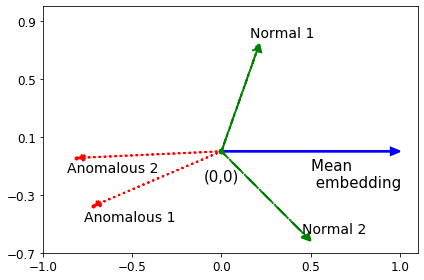

In [923]:
pos = 0
l = 0
i = 0
tot_hr = 0
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
plt.xlim([-1,1.1])
plt.ylim([-0.7,1])
plt.xticks(np.arange(-1,1.5,0.5),fontsize=12)
plt.yticks(np.arange(-.7,1.2,0.4),fontsize=12)
known = [58,74]
i = 1
for instance in [_positive_list[58],_positive_list[74]]:
# for instance in _positive_list: 
    n = instance[0]
    a = instance[1]
    diff_indices = np.nonzero(np.bitwise_xor(n, a))[0]
    n_emb = get_emb_arr(n,domain_emb_dict)
    a_emb = get_emb_arr(a,domain_emb_dict)
    
    norm_n = np.square(np.linalg.norm(np.sum(n_emb,axis=0), ord=2))
    norm_a = np.square(np.linalg.norm(np.sum(a_emb,axis=0), ord=2))
    print(np.tanh(norm_n) , ' || ', np.tanh(norm_a))
    
    a_emb = list(a_emb)
    a_emb.append(np.mean(a_emb, axis=0))
    a_emb = get_reduce_dim(a_emb,2)
    a_emb_mean = n_emb[-1]
    a_emb = a_emb[:-1]
    
    n_emb = list(n_emb)
    n_emb.append(np.mean(n_emb, axis=0))
    n_emb = get_reduce_dim(n_emb,2)
    n_emb_mean = n_emb[-1]
    n_emb = n_emb[:-1]
    
    prj_res = dissect_v4(a_emb)
    print(prj_res)
    n_emb = get_reduce_dim(n_emb,2)
    a_mean = np.sum(a_emb, axis=0)
    n_mean = np.sum(n_emb,axis=0)
    
    _, _, alpha_n = rotate_to_xAxis(n_mean[0],n_mean[1])
    print(' >> ', a_emb_mean)
    # rotate 
    mx,my,alpha = rotate_to_xAxis(a_mean[0],a_mean[1])
    mx = mx/ np.sqrt(mx*mx + my*my )
    my = my/ np.sqrt(mx*mx + my*my )
    mag = np.sqrt (mx**2 + my**2)
    print( 'magnitude of mean', np.sqrt (mx**2 + my**2))
    idx = diff_indices[0]
    target_x, target_y = rotate_by_Beta(a_emb[idx][0], a_emb[idx][1], - alpha) 
#     target_x = target_x/np.sqrt(target_x**2 + target_y**2 )
#     target_y = target_y/np.sqrt(target_x**2 + target_y**2 )
    true_x, true_y = rotate_by_Beta(n_emb[idx][0], n_emb[idx][1], - alpha_n) 

    ax.arrow(0, 0, true_x,true_y, fc="g", ec="g", length_includes_head = True, head_width=0.05,head_length=0.05,linewidth=2,linestyle='-.')
    ax.annotate( 
    'Normal '+str(i), 
    (true_x-0.05, true_y+0.05),
    fontsize=14
    )
    _angle = np.arccos(target_x/(np.sqrt(target_x*target_x + target_y*target_y)))*(180*7/22)
    
    if mag == 1 :
        ax.arrow(0, 0, mx, my, fc="b", ec="b", length_includes_head = True, head_width=0.05,head_length=0.05,linewidth=2)
        ax.annotate( 
        'Mean \n embedding', 
        (mx - 0.5, my - 0.25),
        fontsize=15
        )
    ax.arrow(0, 0, target_x,target_y, fc="r", ec="r", length_includes_head = True, head_width=0.05,head_length=0.05,linewidth=2,linestyle=':')
    ax.plot(target_x, target_y, 'r.')
    ax.annotate( 
     'Anomalous '+str(i), 
     (target_x-0.05, target_y-0.1),
    fontsize=14
    )
    i +=1
plt.plot(0,0,'g.',linewidth=2, markersize=10)
ax.annotate( 
    '(0,0)', 
    (-0.1, -0.2),
    fontsize=15
    )
plt.tight_layout()
plt.savefig('interpretability_fig_v1.pdf')
plt.show() 
    